In [1]:
%load_ext autoreload
%autoreload 2

This notebooks analyzes voicing-related `openSMILE` low-level-descriptors (LLD's) on the parsed (i.e, normalized and converted to 16KhZ mono, see [this notebook](0.4_Parse_Audio_Data.ipynb)) audio data.

In [2]:
import sys
from pathlib import Path
from typing import List, Optional

import pandas as pd
from IPython.display import display
from tqdm.auto import tqdm
from scipy.io import wavfile
import numpy as np
import opensmile
from multiprocessing import Pool
import traceback
from typing import Tuple

sys.path.append("..")
from sgs_utils.path_conf import loc_data_dir, interim_speech_data_dir
from sgs_utils.data_filtering import get_valid_audio_mask
from sgs_utils.processing import sqi_smoothen
from sgs_utils.dataframes import groupby_consecutive

from plotly_resampler import FigureResampler, FigureWidgetResampler
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [3]:
# we utilize the cleaned parquet file obtained by running the 0.1_EDA notebook
df_session = pd.read_parquet(loc_data_dir / "df_session_tot_cleaned.parquet")
df_session_v = df_session[get_valid_audio_mask(df_session)]

# the LLD file that contains the voicing features
df_lld_voiced = pd.read_parquet(loc_data_dir / "voiced_lld.parquet")


In [4]:
# Draw a session of interest
def draw_session(session_of_interest: pd.Series = None, display_stats: bool = False):
    if session_of_interest is None:
        # draw a random session
        session_of_interest = df_session_v.sample(1).iloc[0]

    npy_file = list(
        interim_speech_data_dir.glob(
            f"full_dur_16khz_norm/{session_of_interest.ID}/*/*{session_of_interest.time_str}.npy"
        )
    )[0]
    # x, sr = np.load(npy_file).ravel(), 16_000
    if display_stats:
        display(
            "  -  ".join(
                [
                    npy_file.parent.parent.name.split("__")[-1],
                    npy_file.parent.name,
                    npy_file.stem,
                ]
            )
        )
    # select the corresponding LLD utterance
    df_lld_voiced_utt = df_lld_voiced[
        (df_lld_voiced.ID == session_of_interest.ID)
        & (df_lld_voiced.time_str == session_of_interest.time_str)
    ]
    return npy_file, df_lld_voiced_utt

def construct_fig(df_lld_voiced_utt, npy_file) -> FigureResampler:
    x, sr = np.load(npy_file).ravel(), 16_000
    fr_class = FigureResampler
    fig = fr_class(
        make_subplots(
            rows=3,
            cols=1,
            shared_xaxes=True,
            specs=[[{"secondary_y": True}], [{"secondary_y": True}], [{}]],
        )
    )

    fig.add_trace(
        go.Scattergl(name="audio"),
        hf_x=np.arange(0, step=1 / sr, stop=len(x) / sr)[: len(x)],
        hf_y=x,
        max_n_samples=2000,
    )

    fig.add_trace(
        go.Scattergl(name="audio", line_color='blue', opacity=0.5, showlegend=False),
        hf_x=np.arange(0, step=1 / sr, stop=len(x) / sr)[: len(x)],
        hf_y=x,
        row=2, col=1,
        max_n_samples=2000,
    )

    fig.add_trace(
        go.Scatter(
            x=df_lld_voiced_utt.time_s,
            y=df_lld_voiced_utt["voicingFinalUnclipped_sma"],
            name="voicingFinalUnclipped_sma",
        ),
        row=3,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_lld_voiced_utt.time_s,
            y=df_lld_voiced_utt["voiceProb_sma"],
            name="voiceProb_sma",
        ),
        row=3,
        col=1,
    )

    voiced = (
        (
            (df_lld_voiced_utt.voiceProb_sma > 0.6)
            | (df_lld_voiced_utt.voicingFinalUnclipped_sma > 0.65)
        )
        & (df_lld_voiced_utt.pcm_intensity_sma > 100e-9)
        & (
            (
                (df_lld_voiced_utt.F0final_sma > 80)
                & (df_lld_voiced_utt.F0final_sma < 280)
                # & (df_lld_voiced_utt.logHNR_sma > 3)
            )
        )
    ).rename("voiced")
    voiced.index = df_lld_voiced_utt.time_s
    fig.add_trace(
        go.Scattergl(
            x=df_lld_voiced_utt.time_s,
            y=voiced,
            name="voiced-RAW",
            line_shape="hvh",
            visible="legendonly",
        ),
        row=2,
        col=1,
        secondary_y=True,
    )

    gc = groupby_consecutive(voiced)
    gc["delta"] = gc["end"] - gc["start"]
    for _, r in gc[(gc["delta"] < 0.3) & (gc.voiced == False)].iterrows():
        voiced[r.start - 0.01 : r.next_start] = True
    voiced_sm = sqi_smoothen(
        voiced, fs=100, window_s=0.3, min_ok_ratio=0.65, operation="and"
    )

    fig.add_trace(
        go.Scattergl(
            x=df_lld_voiced_utt.time_s,
            y=voiced,
            name="voiced_agg",
            line_shape="hvh",
        ),
        secondary_y=True,
        row=2,
        col=1,
    )
    fig.add_trace(
        go.Scattergl(
            x=df_lld_voiced_utt.time_s,
            y=voiced_sm,
            name="voiced_smoothened",
            line_shape="hvh",
        ),
        row=2,
        col=1,
        secondary_y=True,
    )

    fig.update_layout(
        height=800,
        template="plotly_white",
        title="  -  ".join(
            [
                npy_file.parent.parent.name.split("__")[-1],
                npy_file.parent.name,
                npy_file.stem,
            ]
        ),
        title_x=0.5,
    )
    fig.update_layout(
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0)
    )

    fig.update_yaxes(categoryarray=["false", "true"])
    return fig

In [5]:
npy_file, df_lld_voiced_utt = draw_session(display_stats=True)
x, sr = np.load(npy_file).ravel(), 16_000


'99d276a0-83fe-4d47-949e-481dc67b2688  -  Radboud  -  Rafd090_05_Caucasian_male_neutral_frontal__12:52:30'

In [6]:
for _, s in tqdm(df_session_v.iterrows(), total=len(df_session_v)):
    try:
        npy_file, df_lld_voiced_utt = draw_session(s, display_stats=False)
        ID = npy_file.parent.parent.name
        DB = npy_file.parent.name
        f_name = npy_file.stem
        fig = construct_fig(df_lld_voiced_utt, npy_file)
        save_dir = interim_speech_data_dir / "vad_images" / ID / DB
        save_dir.mkdir(parents=True, exist_ok=True)
        fig.write_image(save_dir / f"{f_name}.png", width=1300)
    except:
        # print(s.ID, s.pic)
        pass


  0%|          | 0/3029 [00:00<?, ?it/s]

In [7]:
save_dir

PosixPath('/media/SPS/interim/speech_webapp/vad_images/099ceb4d-28f3-4b1f-8f8e-16b439a882f1/marloes')

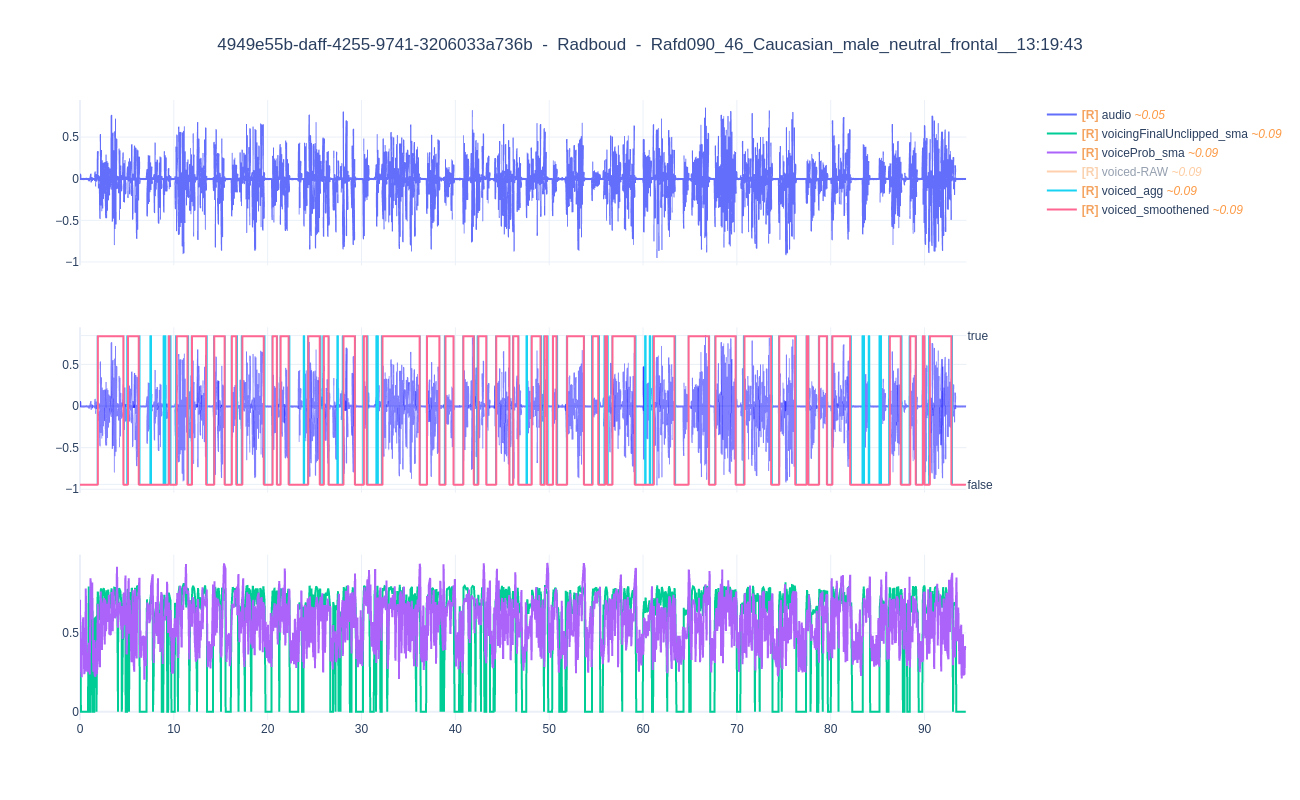

In [72]:
fr_class = FigureResampler


fig = fr_class(
    make_subplots(
        rows=3,
        cols=1,
        shared_xaxes=True,
        specs=[[{"secondary_y": True}], [{"secondary_y": True}], [{}]],
    )
)

fig.add_trace(
    go.Scattergl(name="audio"),
    hf_x=np.arange(0, step=1 / sr, stop=len(x) / sr)[: len(x)],
    hf_y=x,
    max_n_samples=2000,
)

fig.add_trace(
    go.Scattergl(name="audio", line_color='blue', opacity=0.5, showlegend=False),
    hf_x=np.arange(0, step=1 / sr, stop=len(x) / sr)[: len(x)],
    hf_y=x,
    row=2, col=1,
    max_n_samples=2000,
)


fig.add_trace(
    go.Scatter(
        x=df_lld_voiced_utt.time_s,
        y=df_lld_voiced_utt["voicingFinalUnclipped_sma"],
        name="voicingFinalUnclipped_sma",
    ),
    row=3,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=df_lld_voiced_utt.time_s,
        y=df_lld_voiced_utt["voiceProb_sma"],
        name="voiceProb_sma",
    ),
    row=3,
    col=1,
)


# for c in set(df_lld_voiced_utt.columns).difference(
#     {
#         "start",
#         "time_s",
#         "voicingFinalUnclipped_sma",
#         "pic_name",
#         "time_str",
#         "DB",
#         "ID",
#         "voiceProb_sma",
#         "F0_sma",
#     }
# ):
#     fig.add_trace(
#         go.Scatter(
#             name=c,
#             visible="legendonly",
#         ),
#         hf_x=df_lld_voiced_utt.time_s,
#         hf_y=df_lld_voiced_utt[c],
#         row=3,
#         col=1,
#     )

voiced = (
    (
        (df_lld_voiced_utt.voiceProb_sma > 0.6)
        | (df_lld_voiced_utt.voicingFinalUnclipped_sma > 0.65)
    )
    & (df_lld_voiced_utt.pcm_intensity_sma > 100e-9)
    & (
        (
            (df_lld_voiced_utt.F0final_sma > 80)
            & (df_lld_voiced_utt.F0final_sma < 280)
            # & (df_lld_voiced_utt.logHNR_sma > 3)
        )
    )
).rename("voiced")
voiced.index = df_lld_voiced_utt.time_s
fig.add_trace(
    go.Scattergl(
        x=df_lld_voiced_utt.time_s,
        y=voiced,
        name="voiced-RAW",
        line_shape="hvh",
        visible="legendonly",
    ),
    row=2,
    col=1,
    secondary_y=True,
)

gc = groupby_consecutive(voiced)
gc["delta"] = gc["end"] - gc["start"]
for _, r in gc[(gc["delta"] < 0.3) & (gc.voiced == False)].iterrows():
    voiced[r.start - 0.01 : r.next_start] = True
voiced_sm = sqi_smoothen(
    voiced, fs=100, window_s=0.3, min_ok_ratio=0.65, operation="and"
)

fig.add_trace(
    go.Scattergl(
        x=df_lld_voiced_utt.time_s,
        y=voiced,
        name="voiced_agg",
        line_shape="hvh",
    ),
    secondary_y=True,
    row=2,
    col=1,
)
fig.add_trace(
    go.Scattergl(
        x=df_lld_voiced_utt.time_s,
        y=voiced_sm,
        name="voiced_smoothened",
        line_shape="hvh",
    ),
    row=2,
    col=1,
    secondary_y=True,
)

fig.update_layout(
    height=800,
    template="plotly_white",
    title="  -  ".join(
        [
            npy_file.parent.parent.name.split("__")[-1],
            npy_file.parent.name,
            npy_file.stem,
        ]
    ),
    title_x=0.5,
)
# fig.update_layout(
#     legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0)
# )

fig.update_yaxes(categoryarray=["false", "true"])

if fr_class == FigureResampler:
    # fig.show_dash(mode="external", port=9023)
    fig.show(renderer="png", width=1300)
    fig.to_image("")
else:
    display(fig)


In [ ]:
# Iterate over all the LLDS utterances and 